## Build Your Own - Neural Network

In the article I am going to build a neural network from scratch using Numpy in Python. I will start with a very basic model, and slowly add more complex Neural Network architecture. As is the case in this series of articles, I am aiming to build a simple functional model, not the most accurate or complex. The reasoning behind writing these notebooks is so that when I am deploying machine learning models I am confident I understand what is happening 'under the hood'. I feel the benefits of this are two-fold, one being that the explainability of the models becomes easier and they feel less like a black box and two when tuning hyperparameters there is a better understanding of how changing each hyperparameter will impact the training and performance of the model.

We can build any generalized linear model with no interactions using a simple neural network, with no hidden layers. If we use a sigmoid link function then this is simply a logistic regression model. This feels like an easy place to start.

Let's set this up with the familiar Iris dataset, on a binary classification problem for Versicolor or not Versicolor.

In [1]:
import numpy as np
import copy
from numpy.linalg import LinAlgError
from sklearn.datasets import load_iris
df = load_iris(as_frame=True)

Note it is customary in neural networks to set up the data so that the number of rows in the matrix represents the number of predictors and number of columns to be 'm' the number to training data samples, hence we will set up our data in such a way.

In [2]:
X = df.data.values.T
y = ((df.target == 1) * 1).values.reshape(1,150)

We will then scale the data, as this is required in any neural network.

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X.T).T

To set up this model we need to set up a Tensor of weights, of size 1 x 4, a bias value and an activation function. We will initialise our weights to zero for now.

In [4]:
W, b = np.zeros(shape=(1, 4)), np.zeros(shape=(1,1))

Next let's define our activation function. I am including the relu function here, since we will use it later. We could add any number of activations here if required.

In [5]:
def activation(z, func="sigmoid"):
    
    if func == "sigmoid":
        a = 1 / (1 + np.exp(-z))
    elif func == "relu":
        a = (z > 0) * z
    return a

Now we set up a function that forward propagates through one layer of a neural network. Again this should be easily generalizable to more layers with different dimensions, hence we name the parameter A_prev to denote the output from the previous layer. For now this will just take the input X.

In [6]:
def f_prop(A_prev, W, b, func = "sigmoid"):
    
    Z = np.matmul(W, A_prev) + b
    A = activation(Z, func=func)
    return A

It is useful to have a function that computes the cost of our output, which we will attempt to minimize. For a binary classification task, we need to use the binary cross-entropy loss function:

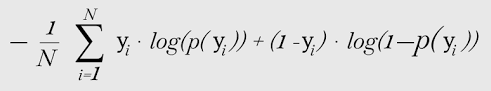

In [7]:
def cost(y, A):
    m = y.shape[1]
    return - np.sum(y * np.log(A) + (1 - y) * np.log(1 - A)) / m

Next, we define a back propagation function that will compute the weight gradients to be used in the optimization algorithm. The gradients are given by the derivatives below, with respect to the activation function being sigmoid and the cost being binary cross-entropy:

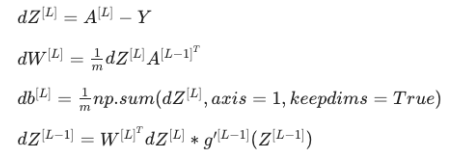

Since our first model will have no hidden layers and we only need to back propagate once, the L-1 layer is not needed yet.

In [8]:
def b_prop(A, A_prev, y, func="sigmoid"):
    
    m = y.shape[1]
    dZ = A - y
    dW = np.matmul(dZ, A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims=True) / m
    
    return dZ, dW, db

Now we can define a fitting function that performs gradient descent with a learning rate alpha and a number of iterations (which is equivalent to the number of epochs). Note we use A_prev = X in the back propogation function.

In [9]:
def fit(X, y, n_iter=1000, alpha=0.1):
    
    W, b = np.zeros((1, 4)), np.zeros(shape=(1,1))
    cost_ = []
    
    for i in range(n_iter):
        A = f_prop(X, W, b, func = "sigmoid")
        dZ, dW, db = b_prop(A, X, y, func="sigmoid")
        W -= alpha * dW
        b -= alpha * db
        cost_.append(cost(y, A))
        
    return W, b, cost_

In [10]:
W, b, cost_ = fit(X, y, n_iter=100, alpha=0.5)
W, b

(array([[-0.00728672, -1.71463174,  0.65527433,  0.13086835]]),
 array([[-0.36381082]]))

As always with these blogs I attempt to replicate the models using machine learning packages. I will do this in Keras.

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input

2024-09-16 17:44:53.259976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here I am defining a simple model with one layer and one unit that takes an input of 4 predictors and a sigmoid activation function. The weights and biases are also initialized at 0 to get the match with our own model, and a gradient descent algorithm (as above). Note I found that I was getting small rounding differences between my model and Keras which compounded over the epochs hence I have set everything to float64.

In [12]:
keras.backend.set_floatx('float64')

model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='zeros', 
                bias_initializer='zeros', dtype="float64"))

sgd = keras.optimizers.SGD(learning_rate=0.5, momentum=0.0)
model.compile(loss='binary_crossentropy', optimizer=sgd)

Now we can set the model to train over 100 iterations, with the batch size set to the size of the training set.

In [13]:
model.fit(X.T, y.T, batch_size=150, epochs=100, verbose=0)
model.get_weights()

[array([[-0.00728672],
        [-1.71463174],
        [ 0.65527433],
        [ 0.13086835]]),
 array([-0.36381082])]

Lets just check the weights from our model match the Keras weights:

In [14]:
print(model.get_weights()[0] - W.T, model.get_weights()[1] - b)

[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.11022302e-16]
 [-1.66533454e-16]] [[0.]]


We can see our model produces the same parameters as Keras. As noted above, we should also be able to create a logistic regression model using our neural network. Let's first train the logistic regression model using SKLearn.

In [15]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(penalty=None)
logmodel.fit(X.T,y.reshape(-1))

print(logmodel.coef_)
print(logmodel.intercept_)

[[-0.88360997 -6.71151201  7.75108954 -6.66827239]]
[1.76598178]


We can see this does not match our model above. Let's try and train our model a bit more to see if our model converges:

In [16]:
W, b, cost_ = fit(X, y, n_iter=100000, alpha=0.5)
W, b

(array([[-0.88327612, -6.71176775,  7.75047705, -6.66801399]]),
 array([[1.76612746]]))

In [17]:
print(logmodel.coef_ - W, logmodel.intercept_ - b)

[[-0.00033385  0.00025574  0.00061249 -0.0002584 ]] [[-0.00014568]]


While the models are not exact, they are close enough, given the different ways they are being trained, and would give very similar performance.

Now let's set up a network with a hidden layer. First we will define a function that creates the matrices of weights and biases, that will form the structure of the model. At the same time let's initialise the weights and bias value using a random normal initialiser (and still 0s for the biases), which is required for deep neural networks. The function takes a list of integers, each specifying the number of neurons in each layer, including the input and output. The function will create list with an item for each hidden and output layer, with an array of weights, biases and a layer number (which acts as an identifier with the first hidden layer labeled 0 to match Python indexing). I have added some checks to ensure the network will fit our training data. I have also scaled the random normal weights by the square root of 2 / the number of units in the layer before in line with generally accepted academic research for efficient gradient descent learning.

In [18]:
def create_network(network_shape :"list of ints", X, y):

    if network_shape[0] != X.shape[0]:
        print("The first dimension of network_shape must match the number of predictors in the training data.")
        return None 
    elif network_shape[-1] != y.shape[0]:
        print("The last dimension  of network_shape must match the features of y in the training data.")
        return None 
    else:
        params = []

        for i in range(len(network_shape)-1):
            w = np.random.randn(network_shape[i+1], network_shape[i]) * np.sqrt(2 / network_shape[i])
            b = np.zeros(shape=(network_shape[i+1], 1))
            layer_number = i
            params.append([w, b, layer_number])
        
        return params        

Lets have a quick look at what this outputs if we chose one hidden layer with 2 units.

In [19]:
network_shape = [4,2,1]
params = create_network(network_shape, X, y)
params

[[array([[ 0.05936724,  0.31715613, -0.2011154 , -0.36079866],
         [ 0.39155555,  0.12939374,  0.21555496, -0.2302387 ]]),
  array([[0.],
         [0.]]),
  0],
 [array([[-0.02752823,  1.06048736]]), array([[0.]]), 1]]

Going back to our back propagation function we need to make a couple of adjustments to train a model with hidden layers.

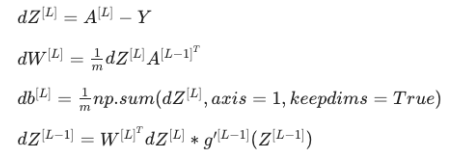

We need to be able to perform the final back propagation step to compute dZ(L-1). Let's define a function for the derivative of our activation functions g'. I won't go through the derivation here since they are easy to find online.

In [20]:
def activation_deriv(z, func="sigmoid"):
    
    if func == "sigmoid":
        a = activation(z, func=func) * (1 - activation(z, func=func))
    elif func == "relu":
        a = (z >= 0) * 1
    return a

Next we need to modify our forward and back propagation functions. The forward propagation function needs to output Z as well as A, since this is required in the back propagation step to compute dZ(L-1). The back propagation function needs a number adjustments which I have outlined line by line in the comments.

In [21]:
def f_prop(A_prev, W, b, func = "sigmoid"):
    
    Z = np.matmul(W, A_prev) + b
    A = activation(Z, func=func)
    return Z, A

# Now takes dZ as inputs Z_prev
def b_prop(A, A_prev, Z_prev, dZ, W, b, func="sigmoid"):
    
    # m changes for a each and takes the number of outputs from the previous layer
    m = A_prev.shape[1]   
    
    # No change to the calculations for dW and db
    dW = np.matmul(dZ, A_prev.T) / m
    db = np.sum(dZ, axis = 1, keepdims=True) / m
    
    # calculate dZ_prev in line with the formulae above
    dZ_prev = np.matmul(W.T, dZ) * activation_deriv(Z_prev, func=func)
    
    # Outputs dZ_prev to be used in back prop for the previous layer
    return dZ_prev, dW, db

Now we need to re-define the fit function. Note that this takes the output from the create_network function and a list of activation functions, as well as the learning hyperparameters. The comments below step through how the function operates.

In [22]:
def fit(X, y,  network_shape, initial_weights, activations, n_iter=1000, alpha=0.1):
    
    # Use deepcopy so that the initialised weights do not get altered and can be used when training 
    # the Keras model
    params = copy.deepcopy(initial_weights)
    cost_ = []
    
    for i in range(n_iter):
        
        # For each epoch we need to record A and Z, the first entry for A is just our training data
        A = [X]
        Z = []
        
        # Loop through the layers using the f_prop function to calculate A and Z for each layer
        for layer in params:
            
            # Define the inputs to the f_prop function
            W = layer[0]
            b = layer[1]
            l = layer[2]
            activation = activations[l]
            A_prev = A[l]
            
            # Perform f_prop and record A and Z to be used in back prop
            z, a = f_prop(A_prev, W, b, func = activation)
            A.append(a)
            Z.append(z)
        
        # Since b_prop takes dZ as an input now, calculate dZ(L) in line with the formulae outlined above
        dZ = [A[-1] - y]
        
        # Loop through the layers in reverse
        for layer in params[::-1]:
            
            # Define the inputs to the b_prop function
            W = layer[0]
            b = layer[1]
            l = layer[2]
            activation = activations[l-1]
            dz = dZ[len(network_shape)-l-2]
            a = A[l+1]
            a_prev = A[l]
            z_prev = Z[l-1]
            
            # Perform b_prop
            dz_prev, dW, db = b_prop(a, a_prev, z_prev, dz, W, b, func=activation)
            
            # Update the parameters using gradient descent
            layer[0] -= alpha * dW
            layer[1] -= alpha * db
            
            # Record dZ_prev to be used in b_prop for the previous layer
            dZ.append(dz_prev)
                        
        # Record the cost of each epoch
        cost_.append(cost(y, A[-1]))
    
    # Output the final weights and biases and the cost
    return params, cost_

Let's test this fitting process and see if it is in-line with a Keras model. First let's define our hyperparameters:

In [23]:
network_shape = [4,20,10,1]
activations=["relu","relu","sigmoid"]
n_iter=2000
alpha=0.1

Now let's initialise our weights to be used in our model and the Keras model.

In [24]:
np.random.seed(1) 
params = create_network(network_shape, X, y)

And train our model.

In [25]:
new_params, cost_ = fit(X, y, network_shape, initial_weights=params, n_iter=n_iter, alpha=alpha, 
                        activations=activations)

I will then collect the weights and biases into a format that can be compared with Keras.

In [26]:
get_weights = []
for layer in new_params:
    get_weights.append(layer[0].T)
    get_weights.append(layer[1].reshape(-1))

Before we look into the model weights, let's have a look at the cost over the epochs to check the gradient descent is working properly.

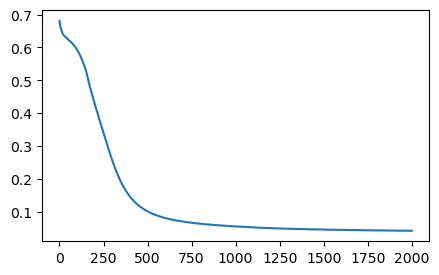

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(cost_)

That looks great. In order to get a matching model in Keras we need to set the initial weights. This requires some re-shaping of our initialised parameters.

In [28]:
set_weights = []
for layer in params:
    set_weights.append(layer[0].T)
    set_weights.append(layer[1].reshape(-1))

Now, let's define our model in Keras using our pre-defined hyperparameters.

In [29]:
model2 = Sequential()
model2.add(Input(shape=(network_shape[0],)))
for i in range(len(activations)):
    model2.add(Dense(units=network_shape[i+1], activation=activations[i], dtype="float64"))

model2.set_weights(set_weights)

sgd = keras.optimizers.SGD(learning_rate=alpha, momentum=0.0)
model2.compile(loss="binary_crossentropy", optimizer=sgd)

In [30]:
model2.fit(X.T, y.T, batch_size=150, epochs=n_iter, verbose=0, shuffle=False)

Comparing the differences between the weights in our models we can see that they are the same.

In [31]:
for i in range(len(get_weights)):
    print(np.round((get_weights[i] - model2.get_weights()[i]).max(), decimals=12))

0.0
0.0
0.0
0.0
0.0
0.0


Finally our model would not be complete with being able to make some predictions. Let's create a function that will take the params output of the fit and create a predict function.

In [32]:
def predict(X, params, activations):
        
        A = [X]
        for layer in params:
            
            W = layer[0]
            b = layer[1]
            l = layer[2]
            activation = activations[l]
            A_prev = A[l]
            z, a = f_prop(A_prev, W, b, func = activation)
            A.append(a)
        
        prediction = (A[-1] > 0.5) * 1
        return A[-1]

Let's make some dummy data.

In [33]:
X_pred = np.random.uniform(size=(4,4))

In [34]:
predict(X_pred, new_params, activations)

array([[1.30499547e-08, 3.65065382e-02, 5.52126674e-03, 6.71544484e-01]])

Comparing to the Keras model we can see the model is predicting binary probabilities correctly too.

In [35]:
(model2.predict(X_pred.T)).T

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[1.30499547e-08, 3.65065382e-02, 5.52126674e-03, 6.71544484e-01]])

That concludes this build your own Neural Network modeling attempt. I hope you enjoyed it!